In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lfwpeople/pairsDevTrain.txt
/kaggle/input/lfwpeople/lfw-funneled.tgz
/kaggle/input/lfwpeople/pairsDevTest.txt
/kaggle/input/lfwpeople/pairs.txt


In [3]:
import os
import tarfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
# Define file paths
tgz_path = "/kaggle/input/lfwpeople/lfw-funneled.tgz"
extract_path = "/kaggle/working/lfw_faces"

# Extract once
if not os.path.exists(extract_path):
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(path=extract_path)
    print("Dataset extracted successfully.")
else:
    print(" Dataset already extracted.")

Dataset extracted successfully.


In [5]:
# Check what's inside extract_path
os.listdir(extract_path)

['lfw_funneled']

In [6]:
# Go inside the Data
nested_path = os.path.join(extract_path, "lfw_funneled")

# List all people (folders)
people = sorted([
    p for p in os.listdir(nested_path)
    if os.path.isdir(os.path.join(nested_path, p))
])

print(" Total people found:", len(people))
print(" First 10 people:", people[:10])

 Total people found: 5749
 First 10 people: ['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban']


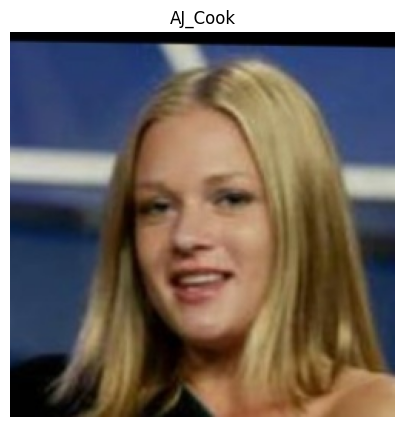

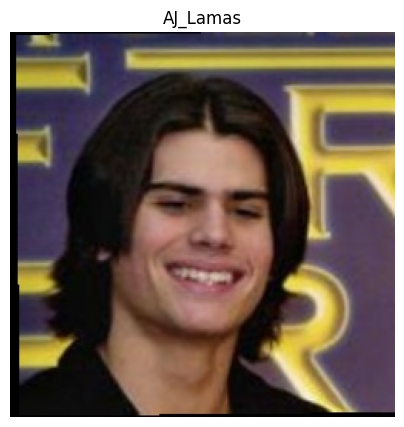

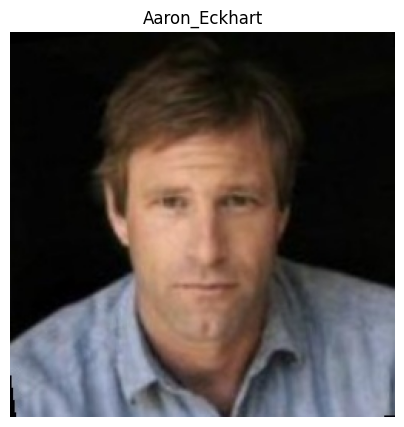

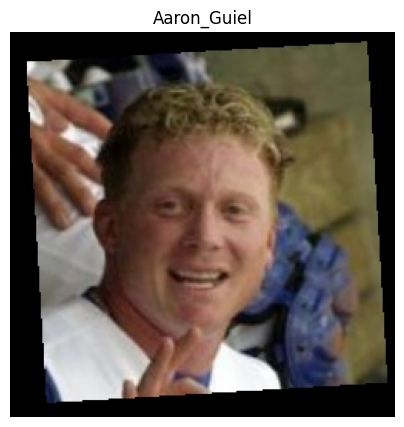

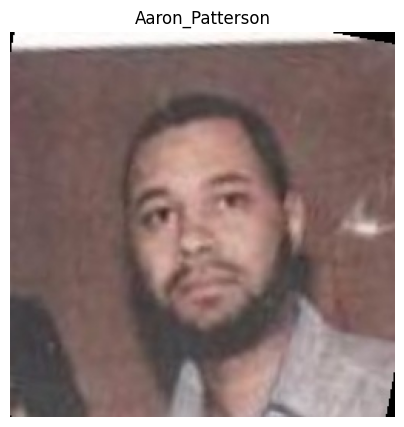

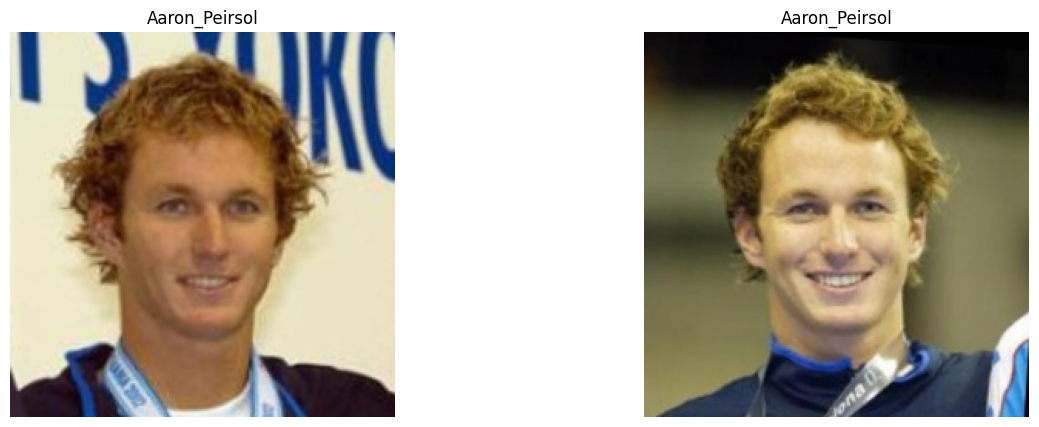

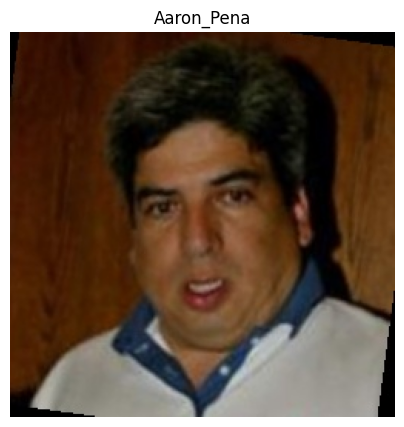

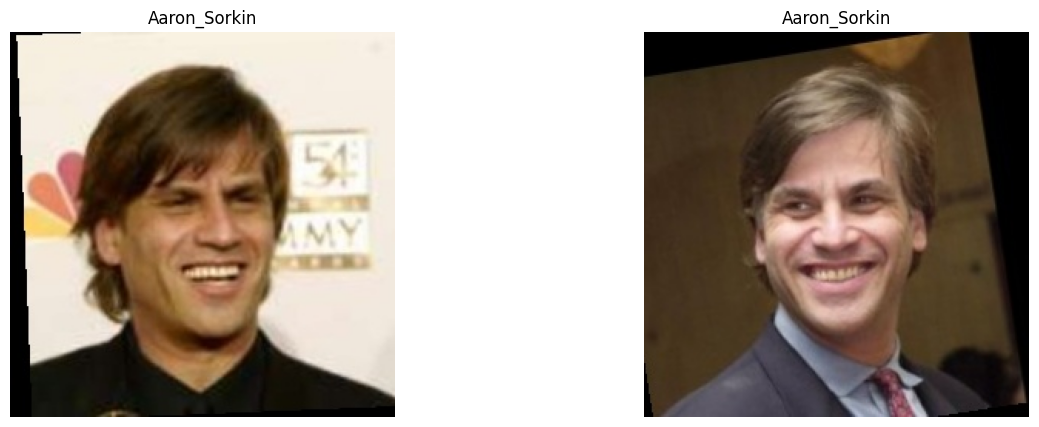

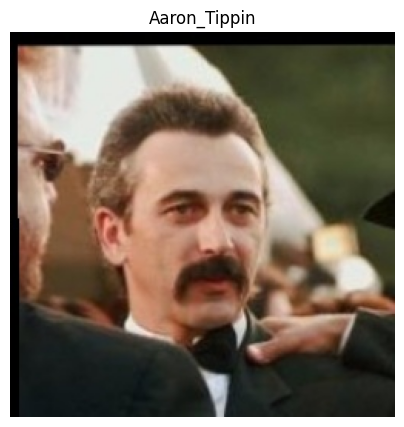

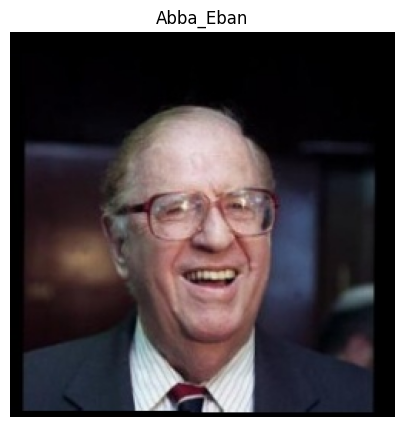

In [7]:
def show_faces(person, num=2):
    person_dir = os.path.join(nested_path, person)
    images = os.listdir(person_dir)[:num]

    plt.figure(figsize=(15,5))
    for i, image in enumerate(images):
        img_path = os.path.join(person_dir, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(person)
        plt.axis('off')
    plt.show()
for person in people[:10]:
    show_faces(person)

In [8]:
import shutil

dataset_path = "/kaggle/working/faces_dataset"
os.makedirs(dataset_path, exist_ok=True)

for person in tqdm(people):
    person_dir = os.path.join(nested_path, person)
    images = os.listdir(person_dir)

    if len(images) < 2:
        continue 

    dest_dir = os.path.join(dataset_path, person)
    os.makedirs(dest_dir, exist_ok=True)

    for img_name in images:
        src_path = os.path.join(person_dir, img_name)
        dst_path = os.path.join(dest_dir, img_name)
        shutil.copy(src_path, dst_path)


#so, faces_dataset is the filtered one by more than or equal images 
#lfw_faces is the original one




100%|██████████| 5749/5749 [00:01<00:00, 5635.98it/s]


2025-11-26 21:44:22.396112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764193462.582497      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764193462.639042      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 8092 images belonging to 1680 classes.
Found 1072 images belonging to 1680 classes.


In [10]:
images, labels = next(train_data)
print(images.shape)
print(labels.shape)


(32, 100, 100, 3)
(32,)


In [11]:
import tensorflow as tf
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

In [12]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 89.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.2

In [13]:
src_root = nested_path
filtered_root = "/kaggle/working/lfw_filtered"
os.makedirs(filtered_root, exist_ok=True)

for person in tqdm(os.listdir(src_root), desc="Filtering persons"):
    person_dir = os.path.join(src_root, person)
    if not os.path.isdir(person_dir):
        continue

    images = os.listdir(person_dir)
    if len(images) < 2:
        continue  # نحتفظ فقط بمن لديهم 2 صورة أو أكثر

    save_dir = os.path.join(filtered_root, person)
    os.makedirs(save_dir, exist_ok=True)

    for img in images:
        src = os.path.join(person_dir, img)
        dst = os.path.join(save_dir, img)
        os.system(f"cp '{src}' '{dst}'")

Filtering persons: 100%|██████████| 5760/5760 [00:24<00:00, 230.46it/s]


In [15]:
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

def detect_and_crop_face(image_path):
    img = cv2.imread(str(image_path))
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)

    if len(faces) == 0:
        return None

    x,y,w,h = faces[0]
    return img[y:y+h, x:x+w]

In [16]:
cropped_root = "/kaggle/working/lfw_cropped"
Path(cropped_root).mkdir(exist_ok=True)

for person in tqdm(os.listdir(filtered_root), desc="Cropping faces"):
    person_dir = Path(filtered_root) / person

    save_dir = Path(cropped_root) / person
    save_dir.mkdir(exist_ok=True)

    for img_name in os.listdir(person_dir):
        img_path = person_dir / img_name
        cropped = detect_and_crop_face(img_path)

        if cropped is not None:
            cv2.imwrite(str(save_dir / img_name), cropped)


Cropping faces: 100%|██████████| 1680/1680 [03:04<00:00,  9.11it/s]


In [18]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

clahe_root = "/kaggle/working/lfw_clahe"
os.makedirs(clahe_root, exist_ok=True)

for person in tqdm(os.listdir(cropped_root), desc="Applying CLAHE"):
    src_p = Path(cropped_root) / person
    dst_p = Path(clahe_root) / person
    dst_p.mkdir(exist_ok=True)

    for img_name in os.listdir(src_p):
        img = cv2.imread(str(src_p/img_name))
        if img is None:
            continue

        ycc = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(ycc)

        y_eq = clahe.apply(y)
        final = cv2.merge([y_eq, cr, cb])
        final = cv2.cvtColor(final, cv2.COLOR_YCrCb2BGR)

        cv2.imwrite(str(dst_p/img_name), final)


Applying CLAHE: 100%|██████████| 1680/1680 [00:08<00:00, 201.41it/s]


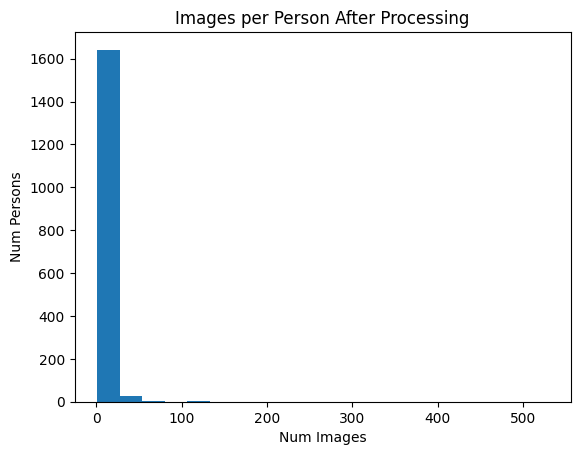

In [20]:
person_counts = {
    person: len(os.listdir(os.path.join(clahe_root, person)))
    for person in os.listdir(clahe_root)
}

plt.hist(list(person_counts.values()), bins=20)
plt.title("Images per Person After Processing")
plt.xlabel("Num Images")
plt.ylabel("Num Persons")
plt.show()


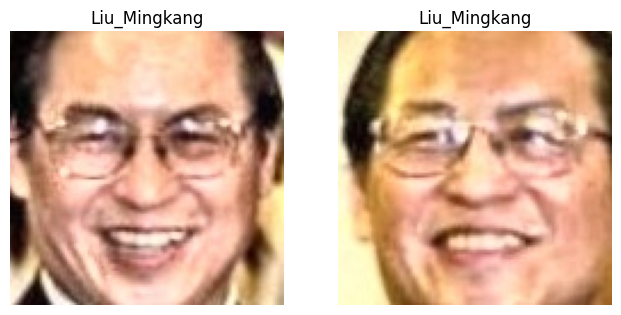

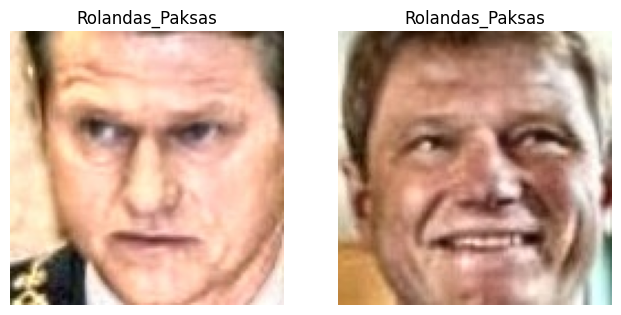

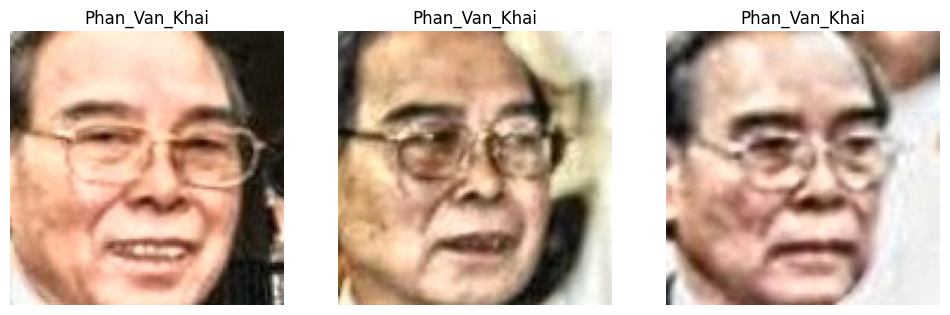

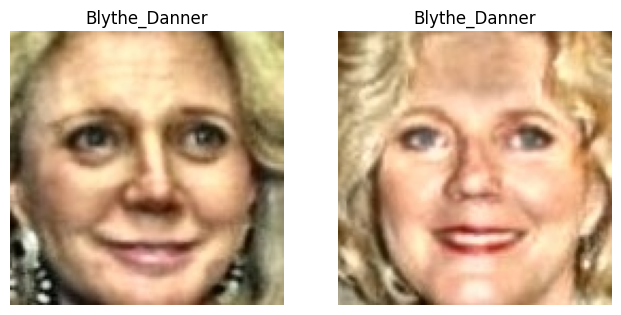

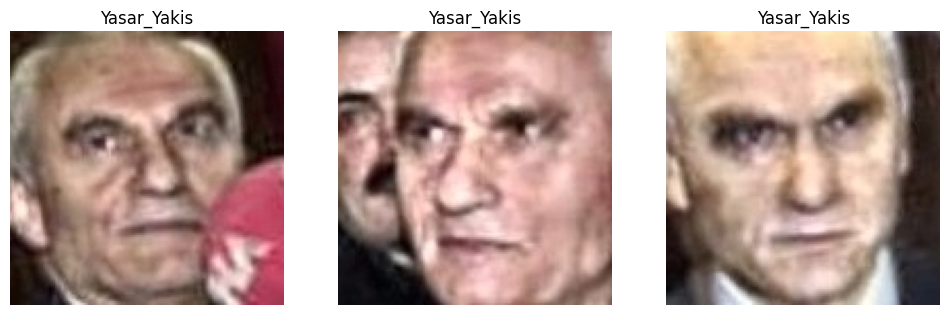

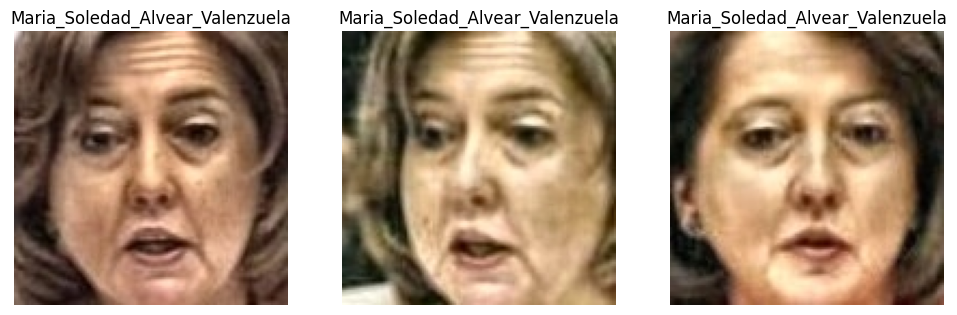

In [21]:
def show_person(person, num=3):
    pdir = os.path.join(clahe_root, person)
    imgs = os.listdir(pdir)[:num]

    plt.figure(figsize=(12,4))
    for i, img_n in enumerate(imgs):
        img = cv2.imread(os.path.join(pdir, img_n))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(person)
        plt.axis('off')
    plt.show()

for p in list(person_counts.keys())[:6]:
    show_person(p)


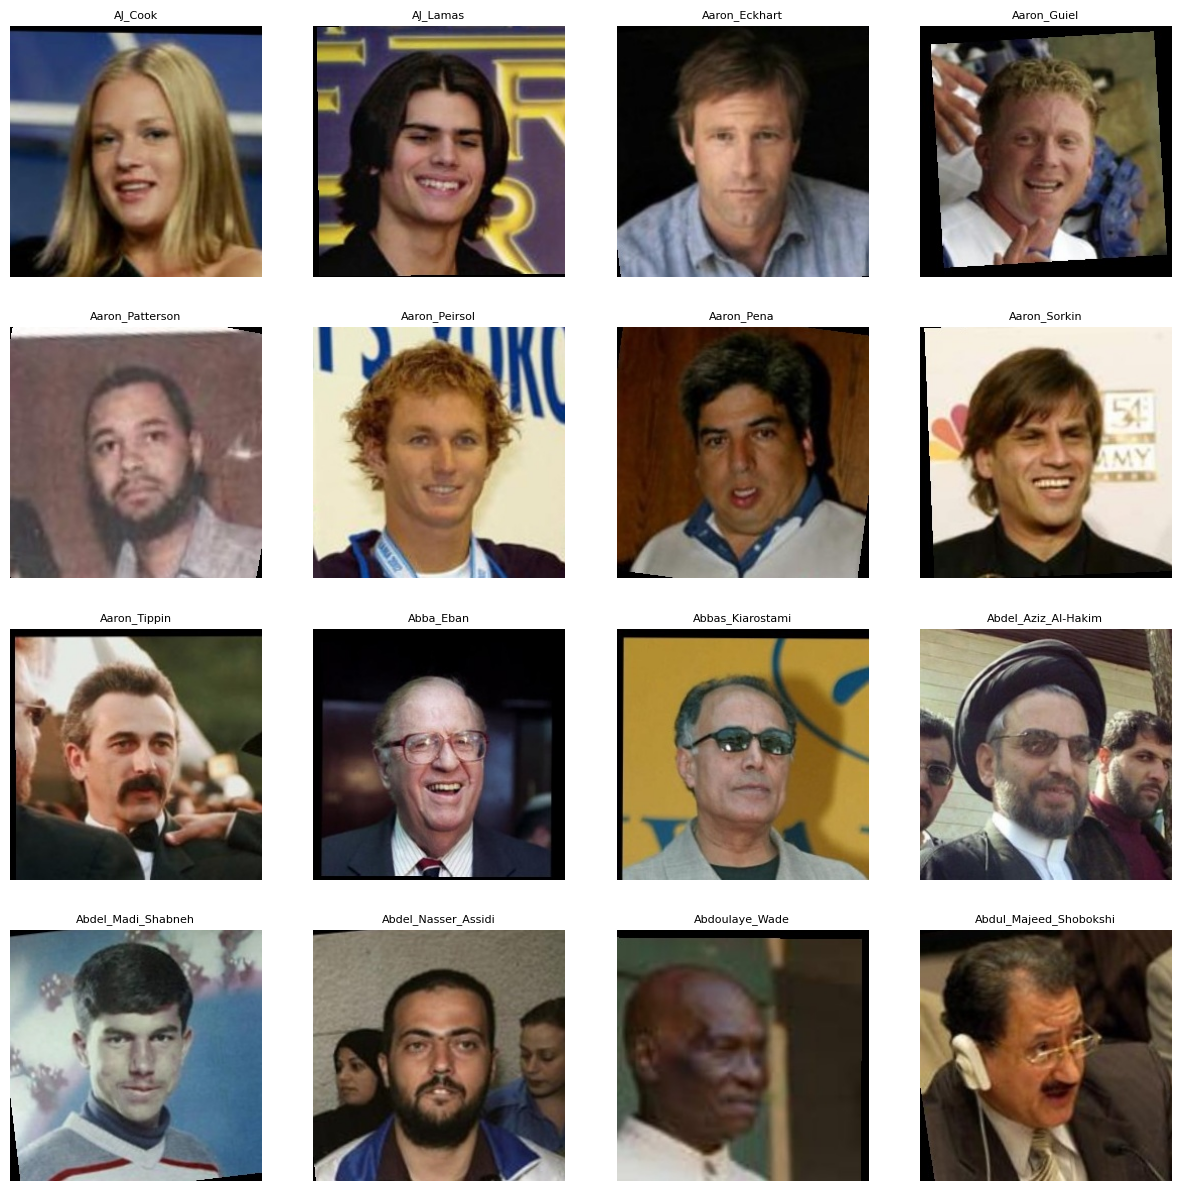

In [19]:
plt.figure(figsize=(15, 15))
for i, person in enumerate(people[:16]):
    person_dir = os.path.join(nested_path, person)
    images = os.listdir(person_dir)
    if len(images) == 0:
        continue
    img_path = os.path.join(person_dir, images[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(person, fontsize=8)
    plt.axis('off')

plt.show()


In [22]:

person_counts = {}
for person in os.listdir(dataset_path):
    person_dir = os.path.join(dataset_path, person)
    if os.path.isdir(person_dir):
        count = len(os.listdir(person_dir))
        person_counts[person] = count

print("Number Of Person", len(person_counts))
print("Example", list(person_counts.items())[:10])


Number Of Person 1680
Example [('Liu_Mingkang', 2), ('Rolandas_Paksas', 2), ('Phan_Van_Khai', 3), ('Blythe_Danner', 2), ('Yasar_Yakis', 4), ('Maria_Soledad_Alvear_Valenzuela', 5), ('Erika_Christensen', 2), ('Robert_Mugabe', 2), ('Courtney_Love', 2), ('Lance_Armstrong', 18)]


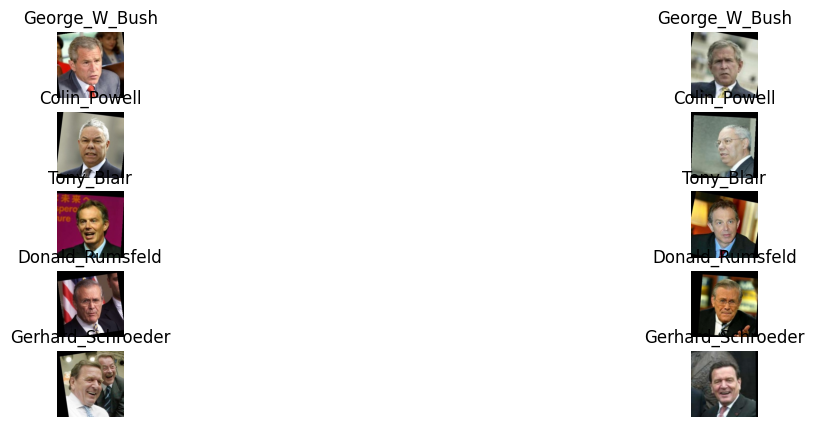

In [24]:
top_people = sorted(person_counts.items(), key=lambda x: x[1], reverse=True)[:5]

plt.figure(figsize=(15, 5))
for i, (person, _) in enumerate(top_people):
    person_dir = os.path.join(dataset_path, person)
    images = os.listdir(person_dir)[:2]
    for j, image in enumerate(images):
        img_path = os.path.join(person_dir, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(len(top_people), 2, i * 2 + j + 1)
        plt.imshow(img)
        plt.title(person)
        plt.axis("off")
plt.show()


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 100
batch_size = 32
# Augmentation generator
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
#  Training data
train_data = train_gen.flow_from_directory(
    clahe_root,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="sparse",
    subset="training"
)
#  Validation data 
val_data = train_gen.flow_from_directory(
    clahe_root,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="sparse",
    subset="validation"
)


Found 8052 images belonging to 1680 classes.
Found 1065 images belonging to 1680 classes.


Total images processed: 13233


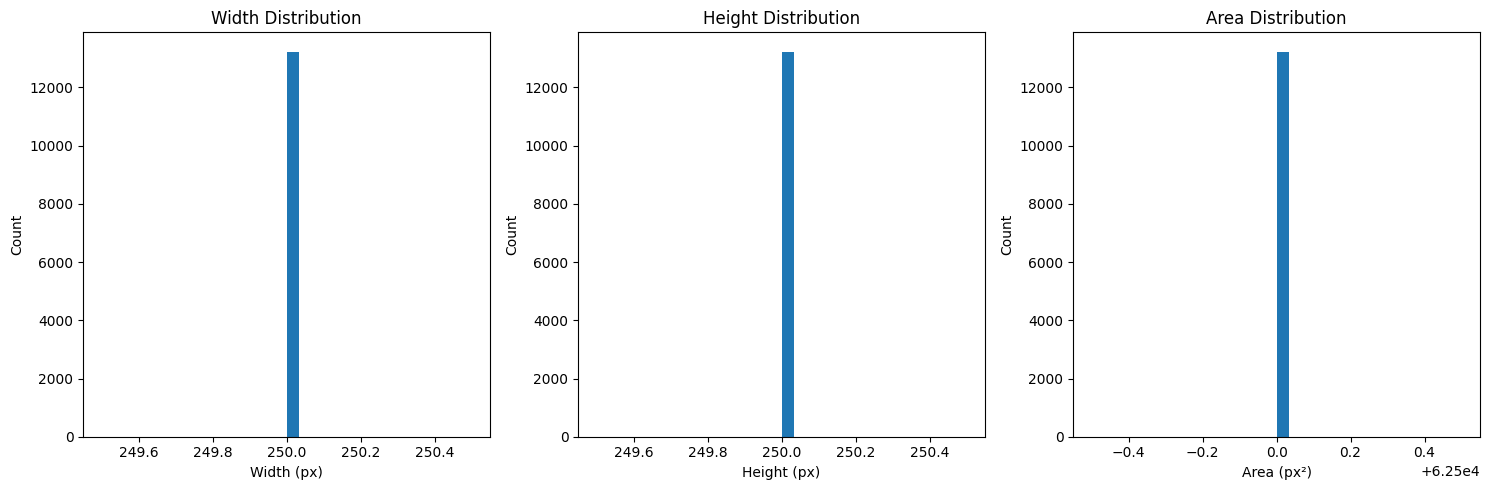

In [27]:
Dataimages = Path(extract_path)

widths, heights, areas = [], [], []
valid_exts = [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"]

for img_path in Dataimages.rglob("*"):
    if img_path.suffix in valid_exts:
        try:
            img = Image.open(img_path)
            w, h = img.size  # (width, height)
            widths.append(w)
            heights.append(h)
            areas.append(w * h)
        except Exception as e:
            print("Could not open:", img_path, "| Error:", e)

print(f"Total images processed: {len(areas)}")

# Plot histograms
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(widths, bins=30)
plt.title("Width Distribution")
plt.xlabel("Width (px)")
plt.ylabel("Count")

plt.subplot(1,3,2)
plt.hist(heights, bins=30)
plt.title("Height Distribution")
plt.xlabel("Height (px)")
plt.ylabel("Count")

plt.subplot(1,3,3)
plt.hist(areas, bins=30)
plt.title("Area Distribution")
plt.xlabel("Area (px²)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [27]:
pairs_train_path = "/kaggle/input/lfwpeople/pairsDevTrain.txt"
pairs_test_path  = "/kaggle/input/lfwpeople/pairsDevTest.txt"

def read_pairs(pairs_file):
    pairs = []
    with open(pairs_file, "r") as f:
        lines = f.readlines()[1:]  # تجاهل السطر الأول اللي فيه عدد الpairs
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 3:  # matched pair
                name, img1, img2 = parts
                pairs.append((name, int(img1), int(img2)))
            elif len(parts) == 4:  # mismatched pair
                name1, img1, name2, img2 = parts
                pairs.append((name1, int(img1), name2, int(img2)))
    return pairs

train_pairs = read_pairs(pairs_train_path)
test_pairs  = read_pairs(pairs_test_path)

print("First 5 train pairs:", train_pairs[:5])


First 5 train pairs: [('Aaron_Peirsol', 1, 2), ('Aaron_Peirsol', 3, 4), ('Aaron_Sorkin', 1, 2), ('Abdel_Nasser_Assidi', 1, 2), ('Abdullah', 1, 3)]


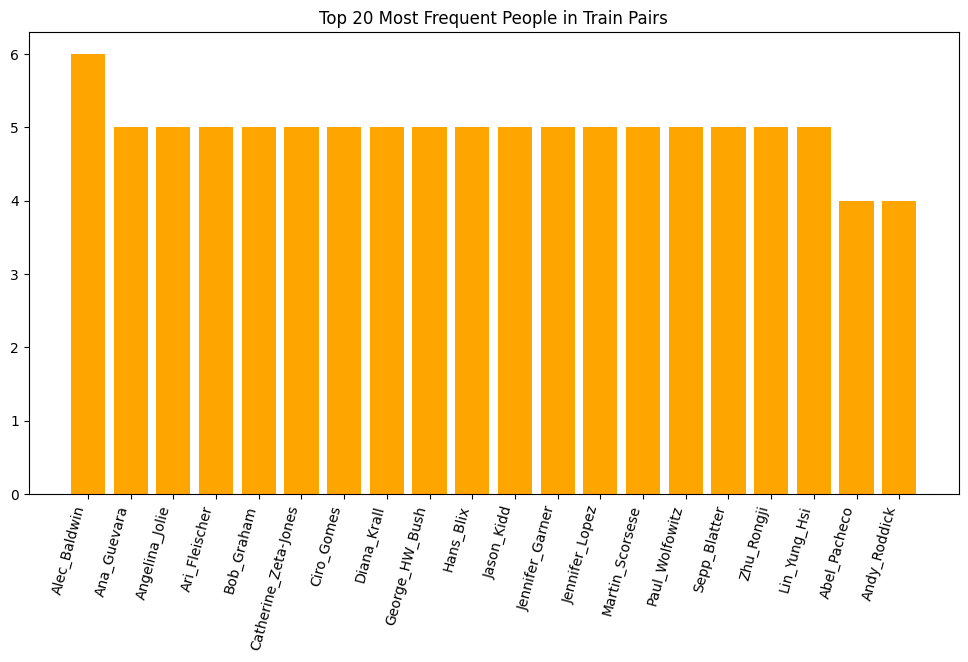

In [28]:
from collections import Counter


train_names = []
for pair in train_pairs:
    if len(pair) == 3:  # matched
        train_names.append(pair[0])
    else:  # mismatched
        train_names.append(pair[0])
        train_names.append(pair[2])

counts_train = Counter(train_names)
top20_train = dict(sorted(counts_train.items(), key=lambda x: x[1], reverse=True)[:20])


plt.figure(figsize=(12,6))
plt.bar(top20_train.keys(), top20_train.values(), color="orange")
plt.xticks(rotation=75, ha="right")
plt.title("Top 20 Most Frequent People in Train Pairs")
plt.show()
